In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from numpy.linalg import inv

### Augmented Dicky Fuller test for staitionary data

### Reading and preparing data

In [2]:
df = pd.read_csv('Data Scientist test set.csv')
dfs = df.dropna().reset_index(drop=True)
dfs.head()

,date,sensor NO2,TEMP,RH,dewpoint,actual NO2
0,1/01/2018 8:00,22.4,8.4,67.5,2.7,30.0
1,1/01/2018 9:00,22.1,8.1,66.3,2.2,30.5
2,1/01/2018 10:00,22.5,7.6,65.2,1.5,29.0
3,1/01/2018 11:00,20.4,6.9,64.5,0.7,27.6
4,1/01/2018 12:00,21.6,6.5,62.1,-0.3,30.2


In [3]:
dfs['date'] = dfs['date'].apply(lambda x : pd.datetime.strptime(x, '%d/%m/%Y %H:%M'))

### Linear regression

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [5]:
rgs = LinearRegression()

#### We divide the time series to training and test set. Test set is used for validating the predictions.

In [6]:
train = dfs[:1800]
test = dfs[1800:]

#### Fitting only on the training set

In [7]:
rgs.fit(train[['sensor NO2', 'TEMP', 'dewpoint', 'RH']], train['actual NO2'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
pred_reg = rgs.predict(dfs[['sensor NO2', 'TEMP', 'dewpoint', 'RH']])

# Kalman Filtering
Another way of analysing sensor data when using data from other sensors is Kalman filtering (for data fusion)

Code adapted from:
https://github.com/PercyJaiswal/Kalman_Filter/blob/master/Kalman%20Filter.py

In [9]:
# Prediction and state matrices
P = np.array([[15., 0.],
              [0., 1.]])
A = np.array([
        [1., 0.],
        [0., 1.]
        ])
H = np.array([1., 1.])
I = np.identity(2)

# initial sensor reading
z = np.transpose(np.array(dfs[['sensor NO2', 'dewpoint']].iloc[0]))

# Measurement and prediction error matrices
R = np.array([
        [dfs['sensor NO2'].var()/15, 0.],
        [0., dfs['dewpoint'].var()]
        ])
Q = 0.05 * np.eye(2)

# initial prediction
x = np.transpose(np.array(dfs[['sensor NO2', 'dewpoint']].iloc[0]))

#**********************Kalman Filter*****************************
def predict():
    # Predict Step
    global x, A, Q, P
    x = np.matmul(A, x)
    At = np.transpose(A)
    P = np.add(np.matmul(A, np.matmul(P, At)), Q)

def update(z):
    # Measurement update step
    global x, P, H, R
    Y = np.subtract(z, np.matmul(H, x))
    Ht = np.transpose(H)
    S = np.add(np.matmul(H, np.matmul(P, Ht)), R)
    K = np.matmul(P, Ht)
    Si = inv(S)
    K = np.matmul(K, Si)
    
    # New state
    x = np.add(x, np.matmul(K, Y))
    P = np.matmul(np.subtract(I ,np.matmul(K, H)), P)

#**********************Iterate through sensor measurements********************
pred_klf = np.zeros(len(dfs))
for i in range (len(dfs)):
    new_measurement = np.transpose(np.array(dfs[['sensor NO2', 'dewpoint']].iloc[i]))
    #Updating sensor readings
    z = new_measurement
    #Collecting ground truths
    ground_truth = dfs['actual NO2'][i]
    #Call Kalman Filter Predict and Update functions.
    predict()
    update(z)
    pred_klf[i] = x[0] 

In comparision both Regression and Kalman filtering increased the match between the sensor and actual data, however, regression tends to generate better results in this case.

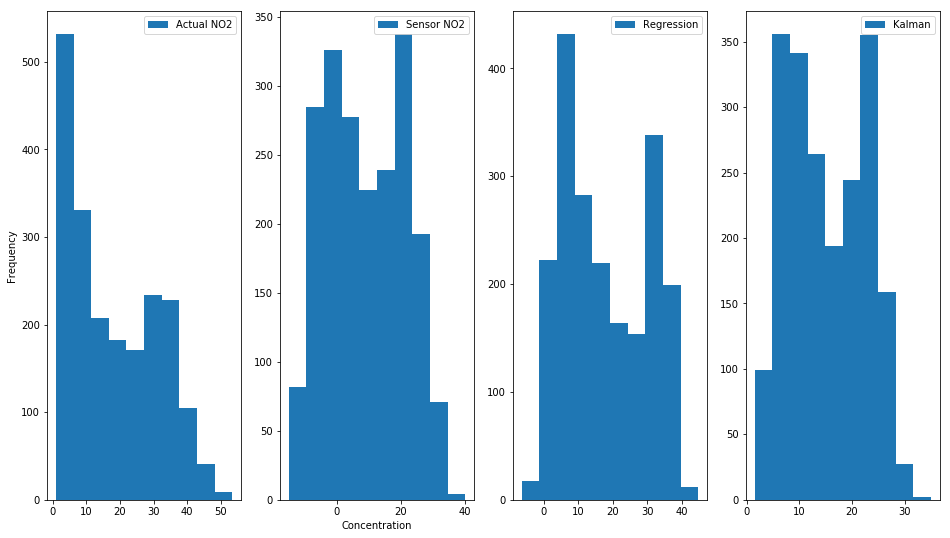

In [22]:
plt.figure(1, figsize=(16, 9))
plt.subplot(141)
plt.hist(dfs['actual NO2'], label='Actual NO2')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(142)
plt.hist(dfs['sensor NO2'], label='Sensor NO2')
plt.xlabel('Concentration')
plt.legend()
plt.subplot(143)
plt.hist(pred_reg, label='Regression')
plt.legend()
plt.subplot(144)
plt.hist(pred_klf, label='Kalman')
plt.legend()

In [25]:
from scipy.stats import shapiro, ttest_ind

## Shapiro-Wilk test of normality

In [23]:
_, p_act = shapiro(dfs['actual NO2'])
_, p_sns = shapiro(dfs['sensor NO2'])
_, p_reg = shapiro(pred_reg)
_, p_klf = shapiro(pred_klf)

In [24]:
print('p-value for Actual data: {0}'.format(p_act))
print('p-value for Sensor data: {0}'.format(p_sns))
print('p-value for Regression: {0}'.format(p_reg))
print('p-value for Kalman: {0}'.format(p_klf))

p-value for Actual data: 5.384077396010571e-32
p-value for Sensor data: 8.549895371838788e-24
p-value for Regression: 2.0652239560896195e-30
p-value for Kalman: 1.5738533105185296e-25


## T-Test
If we assume that the data set is a subset of a larger one.

Normality tests reject the null hypothesis that the data for all four distributions are coming from a normal distribution, however, according to the Central Limit Theorem we may assume that we have enough data for a normal distribution so we run t-test to check the similarity of the average of the estimates to the actual data. 

In [28]:
_, p_tt_act_sns = ttest_ind(dfs['actual NO2'], dfs['sensor NO2'])
_, p_tt_act_reg = ttest_ind(dfs['actual NO2'], pred_reg)
_, p_tt_act_klf = ttest_ind(dfs['actual NO2'], pred_klf)

In [29]:
print('p-value for Actual data_Sensor data ttest: {0}'.format(p_tt_act_sns))
print('p-value for Actual data_Regression ttest: {0}'.format(p_tt_act_reg))
print('p-value for Actual data_Kalman ttest: {0}'.format(p_tt_act_klf))

p-value for Actual data_Sensor data ttest: 5.3157166460023694e-110
p-value for Actual data_Regression ttest: 0.4743790535540757
p-value for Actual data_Kalman ttest: 5.040646082631578e-18


Only **Regression** does not reject the null hyothesis which means that the larger population of the regression estimation shows no difference with the actual sensor data in their means.

Here again Regression performs better.